In [1]:
import torch

def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

No GPU available, using the CPU instead.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [3]:
if IN_COLAB:
    PATH_TO_DATA = '/content/'
else:
    PATH_TO_DATA = './data/'

# Copy data 

In [5]:
BASE_PATH = '/content/drive/MyDrive/ai/detect-flood-water/'

In [6]:
!ls {BASE_PATH}

detect-flood-water	flood-training-metadata.csv  pth_save
flood-train-images.tgz	flood-train-labels.tgz	     training_results.ipynb


In [7]:
%%time
file_name = 'flood-train-images.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 242 ms, sys: 59.8 ms, total: 302 ms
Wall time: 35.8 s


In [8]:
%%time
file_name = 'flood-train-labels.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 17 ms, sys: 17.8 ms, total: 34.8 ms
Wall time: 1.54 s


In [9]:
file_name = 'flood-training-metadata.csv'
file_path = BASE_PATH + file_name

!cp {file_path} .

# Imports

In [4]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [5]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [12]:
os.chdir("/content/drive/My Drive/ai/detect-flood-water/detect-flood-water/")

In [13]:
!pip install rasterio
!pip install pandas_path
!pip install segmentation_models_pytorch

     |████████████████████████████████| 19.3 MB 1.4 MB/s 
     |████████████████████████████████| 87 kB 5.0 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 376 kB 33.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=da6143e748c8e721348557019720f8c80b92915ee40231b133e70f1bc16ca773
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=100f7ea4f9a6e170c2949c09e9e701b6b7c46f2fe77e528bf721de1b08ff6811
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [6]:
from utils import seed_everything
from dataset import FloodDataset

from plot_utils import show_image, show_image_and_label, show_train_metrics, show_loss_and_score

In [7]:
seed = 2021
seed_everything(seed)

In [8]:
import warnings

warnings.filterwarnings("ignore")

In [9]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

# Git repo 

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   dataset.py
	modified:   detect-flood-water-train.ipynb
	modified:   main.py
	modified:   metrics.py
	modified:   plot_utils.py
	modified:   train.py
	modified:   transform.py

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
# !git diff train.py

In [ ]:
!git add .

In [ ]:
!git config --global user.email "michael.kalinin.nn@gmail.com"
!git config --global user.name "michaelka"

In [ ]:
!git commit -m "[colab] IoU by flood id"

[master ce048bd] [colab] IoU by flood id
 7 files changed, 127 insertions(+), 5057 deletions(-)
 rewrite detect-flood-water-train.ipynb (69%)


In [ ]:
!git push origin master

Counting objects: 9, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 2.25 MiB | 4.75 MiB/s, done.
Total 9 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/MIchaelKa/detect-flood-water.git
   94d3779..ce048bd  master -> master


# Load data 

In [10]:
from pathlib import Path
from pandas_path import path
from main import get_paths_by_chip

In [11]:
os.listdir(PATH_TO_DATA)

['flood-training-metadata.csv', 'train_features', 'train_labels']

In [12]:
train_metadata = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'flood-training-metadata.csv'),
    parse_dates=["scene_start"]
)
train_metadata.shape

(1084, 6)

In [13]:
DATA_PATH = Path(PATH_TO_DATA)

In [14]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

In [15]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [16]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,data/train_features/awc00_vh.tif,data/train_labels/awc00.tif
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,data/train_features/awc00_vv.tif,data/train_labels/awc00.tif
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,data/train_features/awc01_vh.tif,data/train_labels/awc01.tif
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,data/train_features/awc01_vv.tif,data/train_labels/awc01.tif
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,data/train_features/awc02_vh.tif,data/train_labels/awc02.tif


In [17]:
train_metadata.shape

(1084, 8)

In [18]:
train_metadata = get_paths_by_chip(train_metadata)

print(len(train_metadata))
train_metadata.head()

542


,chip_id,vv_path,vh_path,flood_id
0,awc00,data/train_features/awc00_vv.tif,data/train_features/awc00_vh.tif,awc
1,awc01,data/train_features/awc01_vv.tif,data/train_features/awc01_vh.tif,awc
2,awc02,data/train_features/awc02_vv.tif,data/train_features/awc02_vh.tif,awc
3,awc03,data/train_features/awc03_vv.tif,data/train_features/awc03_vh.tif,awc
4,awc04,data/train_features/awc04_vv.tif,data/train_features/awc04_vh.tif,awc


# Split data

In [ ]:
import random
from main import get_paths_by_chip

In [ ]:
# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids = ['qus', 'hxu', 'pxs']
val_flood_ids = ['kuo', 'tht', 'qus']
val_flood_ids

['kuo', 'tht', 'qus']

In [ ]:
valid_df = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train_df = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [ ]:
# Separate features from labels
val_x = get_paths_by_chip(valid_df)
val_y = valid_df[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train_df)
train_y = train_df[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [ ]:
len(val_x) / (len(val_x) + len(train_x)) * 100

23.062730627306273

 # Dataset

In [19]:
from main import prepare_data, get_dataset
from plot_utils import show_dataset

In [20]:
reduce_train = False
train_number = 32
valid_number = 32

# seed = 2022
seed_everything(seed)

train_x, train_y, val_x, val_y = prepare_data(PATH_TO_DATA, reduce_train, train_number, valid_number)

[data] flood_ids: ['qus', 'hxu', 'pxs']
[data] Dataset size, train: 418, valid: 124, ratio: 22.878228782287824


In [21]:
train_dataset, valid_dataset = get_dataset(
    PATH_TO_DATA,
    reduce_train,
    train_number,
    valid_number
)

[data] flood_ids: ['qus', 'hxu', 'pxs']
[data] Dataset size, train: 418, valid: 124, ratio: 22.878228782287824


[0 1 2 3 4]


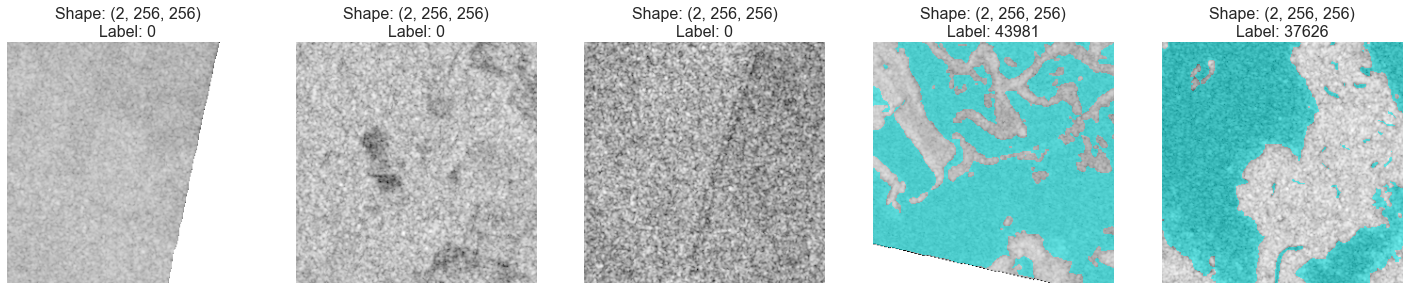

In [ ]:
show_dataset(train_dataset, 0, 5)

In [ ]:
train_x.head()

,chip_id,vv_path,vh_path,flood_id
0,awc00,data/train_features/awc00_vv.tif,data/train_features/awc00_vh.tif,awc
1,awc01,data/train_features/awc01_vv.tif,data/train_features/awc01_vh.tif,awc
2,awc02,data/train_features/awc02_vv.tif,data/train_features/awc02_vh.tif,awc
3,awc03,data/train_features/awc03_vv.tif,data/train_features/awc03_vh.tif,awc
4,awc04,data/train_features/awc04_vv.tif,data/train_features/awc04_vh.tif,awc


In [ ]:
train_dataset_orig = FloodDataset(train_x, train_y, transforms=None)

[5 6 7 8 9]


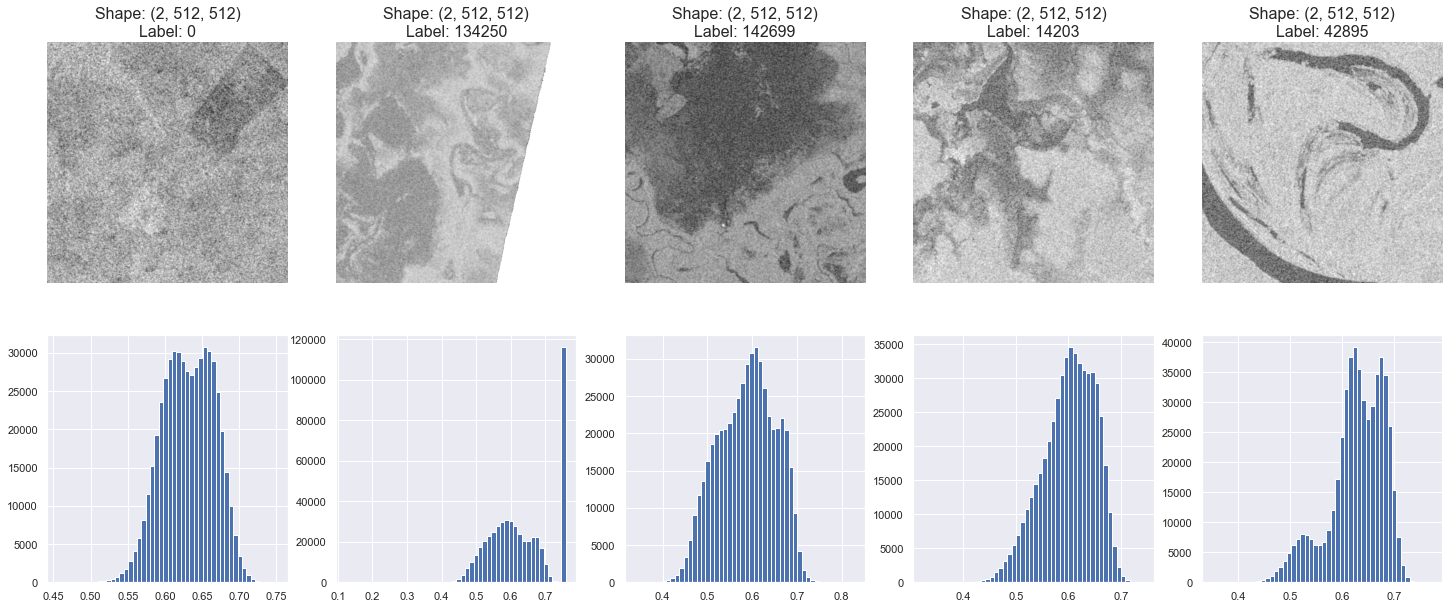

In [ ]:
show_dataset(train_dataset_orig, 5, 5, show_mask=False, show_hist=True)

In [ ]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(train_dataset_orig) // 5,
    step=1,
    description='Index:',
    disabled=False
)

def handle_change(x):
    show_dataset(train_dataset_orig, x*5, 5)

In [ ]:
from transform import get_train_transform

In [18]:
import albumentations as A

In [19]:
limit_single = -0.3

def get_train_transform(crop_size):
    transform = A.Compose([
#         A.RandomCrop(crop_size, crop_size),
        
        #
        # Color
        #
        
#         A.RandomBrightness(
#             limit=(limit_single,limit_single),
#             p=1
#         )
        
#         A.RandomBrightnessContrast(
#             brightness_limit=0,
#             contrast_limit=(limit_single,limit_single),
#             p=1
#         ),
        
        A.CLAHE(p=1),
        
        #
        # Geometric
        #
        
#         A.RandomRotate90(),
#         A.HorizontalFlip(),
#         A.VerticalFlip(),

        
#         A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
        
        
        # distort_limit=0.5
#         A.GridDistortion(
#             num_steps=5,
#             distort_limit=0.3,
# #             border_mode=0,
#             p=1
#         )
        
        # distort_limit=(1,1)
        # A.OpticalDistortion(
        #     distort_limit=(0,1),
        #     shift_limit=0.5,
        #     # border_mode=0,
        #     p=1
        # )
        
        
#         A.RandomSizedCrop(
#             min_max_height=(50, 512),
#             height=crop_size,
#             width=crop_size,
#             p=1
#         )

    ])
    return transform

In [ ]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Index:', max=75), Output()), _dom_classes=('widget-…

<function __main__.handle_change(x)>

In [ ]:
crop_size = 256
train_dataset = FloodDataset(train_x, train_y, transforms=get_train_transform(crop_size))

[5 6 7 8 9]


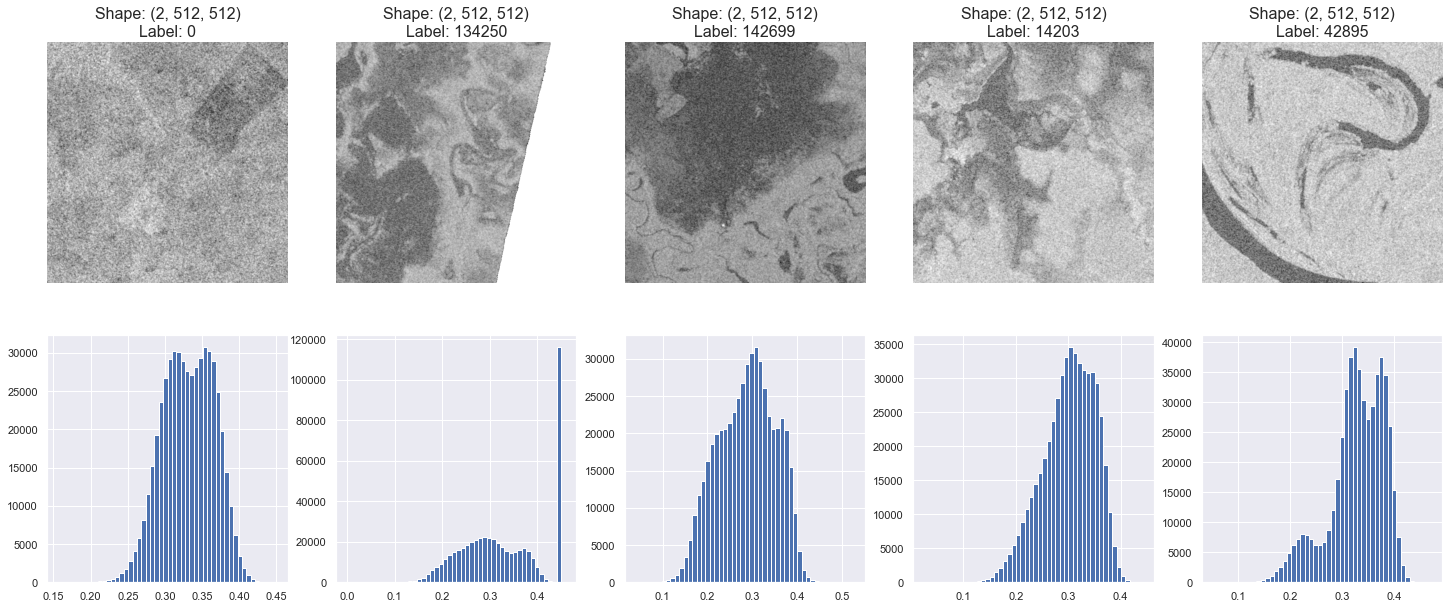

In [ ]:
start_index = 1
show_dataset(train_dataset, start_index*5, 5, show_mask=False, show_hist=True)

In [ ]:
sample_data = train_dataset[0]
chip = sample_data['chip']
label = sample_data['label']

chip.shape, label.shape

((2, 256, 256), (256, 256))

In [ ]:
label_to_show = np.ma.masked_where((label == 0) | (label == 255), label)

In [ ]:
256*256

65536

In [ ]:
(1 - label_to_show.mask).sum()

0

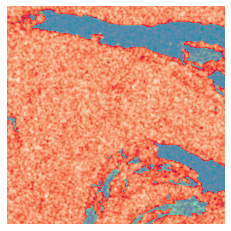

In [ ]:
label_to_show = np.ma.masked_where((label == 0) | (label == 255), label)
show_image_and_label(chip[1], label_to_show)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)
len(train_loader)

14

In [ ]:
%%time
for i, x in enumerate(train_loader):
    pass

CPU times: user 12.1 s, sys: 788 ms, total: 12.8 s
Wall time: 12.8 s


# Scheduler

In [ ]:
from main import get_scheduler, test_scheduler

In [ ]:
scheduler_params = dict(
    name = 'MultiStepLR', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [1, 50, 200],
    gamma = 0.4,
    
    # OneCycleLR
#     max_lr = 0.3,
#     pct_start = 0.3,
)

In [ ]:
learning_rate = 0.001
max_iter = 300
scheduler_params

{'name': 'MultiStepLR', 'milestones': [1, 50, 200], 'gamma': 0.4}

In [ ]:
lr_history = test_scheduler(learning_rate, max_iter, scheduler_params)

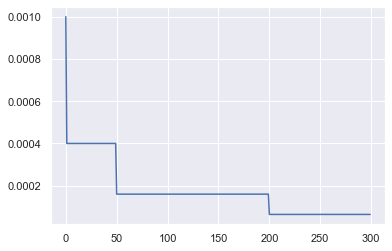

In [ ]:
plt.plot(lr_history)

# Memory

In [ ]:
from utils import display_memory, get_num_of_params
from train import set_encoder_grad

In [ ]:
display_memory(device)
X = torch.randn(32, 2, 256, 256).to(device)
display_memory(device) # 32*2*256*256*4 / 1024 ** 3

0.291 GB
0.306 GB


In [ ]:
32*2*256*256*4 / 1024 ** 3

0.015625

In [ ]:
%%time

display_memory(device)

model = get_model().to(device)
# set_encoder_grad(model, False)

output = model(X)
print(output.shape)

display_memory(device)
del output
display_memory(device)

0.330 GB
torch.Size([32, 2, 256, 256])
6.195 GB
0.309 GB
CPU times: user 235 ms, sys: 23.3 ms, total: 259 ms
Wall time: 258 ms


In [ ]:
get_num_of_params(model)

8756962

In [ ]:
# model

## Single model pass

In [26]:
import segmentation_models_pytorch as smp

In [41]:
encoder_name = 'resnet18'
encoder_weights = 'imagenet'

model = smp.DeepLabV3(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=2,
    classes=2,
)

In [51]:
decoder_channels = 256
model.decoder = smp.deeplabv3.decoder.DeepLabV3Decoder(
    in_channels=model.encoder.out_channels[-1],
    out_channels=decoder_channels,
    atrous_rates=(6, 8, 12)
)

In [60]:
# model

In [53]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [54]:
train_loader_iter = iter(train_loader)

In [55]:
data_dict = next(train_loader_iter)

id_batch = data_dict['chip_id']
x_batch = data_dict['chip'].to(device)
y_batch = data_dict['label'].to(device)

x_batch.shape, y_batch.shape

(torch.Size([4, 2, 256, 256]), torch.Size([4, 256, 256]))

In [56]:
output = model.encoder(x_batch)

In [57]:
len(output)

6

In [58]:
for o in output:
    print(o.shape)

torch.Size([4, 2, 256, 256])
torch.Size([4, 64, 128, 128])
torch.Size([4, 64, 64, 64])
torch.Size([4, 128, 32, 32])
torch.Size([4, 256, 32, 32])
torch.Size([4, 512, 32, 32])


In [59]:
output = model(x_batch)
print(output.shape)

torch.Size([4, 2, 256, 256])


In [ ]:
from loss import XEDiceLoss

In [33]:
# loss = smp.utils.losses.DiceLoss()
loss = nn.CrossEntropyLoss(ignore_index=255)

In [34]:
y_batch = y_batch.type(torch.long)
# y_batch = y_batch.unsqueeze(1)
loss_value = loss(output, y_batch)
loss_value

tensor(0.6939, grad_fn=<NllLoss2DBackward>)

In [ ]:
loss = XEDiceLoss()

In [ ]:
loss_value = loss(output, y_batch)
loss_value

tensor(0.7426, device='cuda:0', grad_fn=<AddBackward0>)

# Run

In [61]:
from main import run, get_model
from plot_utils import show_valid_score_by_flood

In [70]:
# timm-efficientnet-b0, efficientnet-b0, resnet18, resnet34, se_resnext50_32x4d
encoder_name = 'timm-efficientnet-b0'
model_name = 'deeplabv3'

### Debug training

In [63]:
scheduler_params = dict(
    name = 'MultiStepLR', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [1, 2, 3],
    gamma = 0.5,
)

debug_params = dict(
    reduce_train=True,
    train_number=20,
    valid_number=4,

    batch_size_train=2,
    batch_size_valid=2,
    max_iter=5,
    valid_iters=[1, 3, 4],
    unfreeze_iter=0,
    
    scheduler_params=scheduler_params,
    
    save_model=False,
)

In [64]:
small_dataset_params = dict(
    reduce_train=True,
    train_number=32,
    valid_number=16,

    batch_size_train=4,
    batch_size_valid=4,
    max_iter=200,
    valid_iters=[10, 50, 100, 150, 199],
    
    save_model=False,
)

### Full training

In [65]:
num_train_samples = 9600
batch_size_train = 16

max_iter = num_train_samples // batch_size_train
num_train_samples = batch_size_train * max_iter

max_iter, num_train_samples

(600, 9600)

In [66]:
# max_iter=300
# valid_iters=[50, 100, 150, 200, 250, 299]

# max_iter=100
# valid_iters=[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]

max_iter=480
valid_step=30
unfreeze_iter=0 # 90

valid_iters = list(np.arange(valid_step-1, max_iter, valid_step))
valid_iters

[29, 59, 89, 119, 149, 179, 209, 239, 269, 299, 329, 359, 389, 419, 449, 479]

In [74]:
scheduler_params = dict(
    name = 'None', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [300],
    gamma = 0.4,
    
    # OneCycleLR
    max_lr = 0.3,
    pct_start = 0.3,
)

full_params = dict(
    reduce_train=False,
    train_number=0,
    valid_number=0,

    batch_size_train=32,
    batch_size_valid=32,
    max_iter=max_iter,
    unfreeze_iter=unfreeze_iter,
#     valid_iters=valid_iters
    
    scheduler_params=scheduler_params,
    
    save_model=True,
    model_save_name=f'{model_name}_{encoder_name}_V1_11.09'
)

In [81]:
params = dict(
    path_to_data=PATH_TO_DATA,

    optimizer_name='Adam',
    learning_rate=3e-4, # 5e-4, 3e-4, 1e-3
    weight_decay=0,

    verbose=True
)

params.update(debug_params) # full_params, debug_params, small_dataset_params

In [82]:
params

{'path_to_data': './data/',
 'optimizer_name': 'Adam',
 'learning_rate': 0.0003,
 'weight_decay': 0,
 'verbose': True,
 'reduce_train': True,
 'train_number': 20,
 'valid_number': 4,
 'batch_size_train': 2,
 'batch_size_valid': 2,
 'max_iter': 5,
 'valid_iters': [1, 3, 4],
 'unfreeze_iter': 0,
 'scheduler_params': {'name': 'MultiStepLR',
  'milestones': [1, 2, 3],
  'gamma': 0.5},
 'save_model': False}

In [33]:
other_params = dict(
    valid_iters=valid_iters,
#     scheduler_params=scheduler_params
)
params.update(other_params)

In [85]:
seed = 2021
seed_everything(seed)

model = get_model(encoder_name).to(device)

train_info = run(model, device, **params)

[run]
[data] flood_ids: ['kuo', 'tht', 'qus']
[data] Dataset size, train: 417, valid: 125, ratio: 23.062730627306273
[data] Reduced dataset size, train: 20, valid: 4
[data] DataLoader size, train: 10, valid: 2
[data] num_epoch: 0.5, num_train_samples: 10
[train] started...
[train] iter:    1, loss = 0.66056, score = 0.29771, time: 0:00:17
[valid] iter:    1, loss = 0.70289, score = 0.00832, time: 0:00:17
[valid] iter:    1, score = {'kuo': 0.008319472894072533}

[train] iter:    3, loss = 0.65871, score = 0.25520, time: 0:00:34
[valid] iter:    3, loss = 0.70975, score = 0.00585, time: 0:00:34
[valid] iter:    3, score = {'kuo': 0.00585201708599925}

[train] iter:    4, loss = 0.65650, score = 0.23487, time: 0:00:49
[valid] iter:    4, loss = 0.74525, score = 0.00648, time: 0:00:49
[valid] iter:    4, score = {'kuo': 0.0064782146364450455}

[valid] best score = 0.00832, iter:    1
[train] finished for: 0:00:49


In [80]:
# model

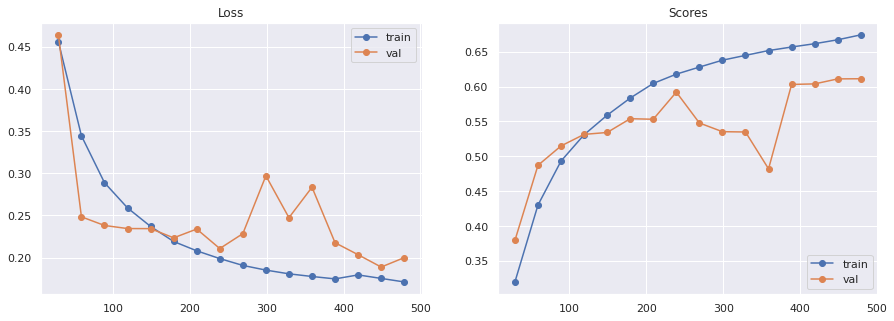

In [35]:
# show_loss_and_score(train_info, start_from=1)
show_loss_and_score(train_info)

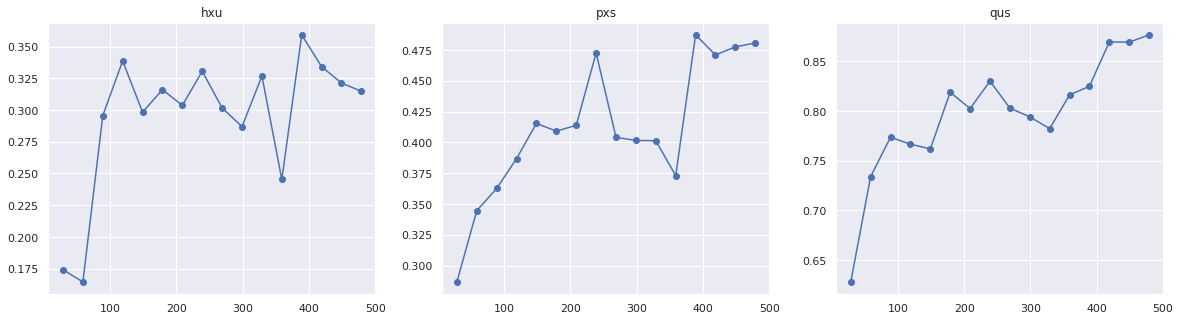

In [36]:
show_valid_score_by_flood(train_info)

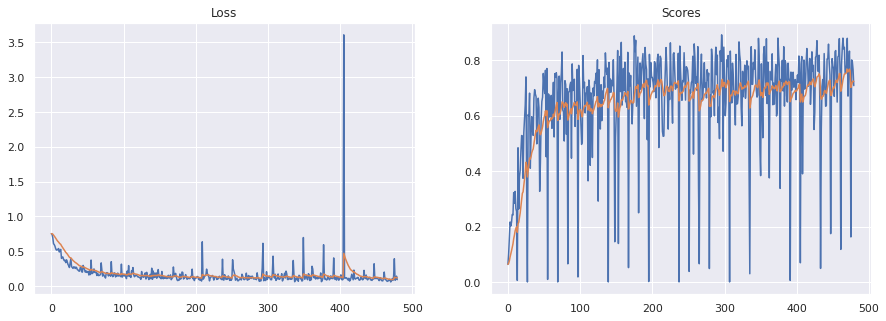

In [37]:
loss_meter = train_info['train_loss_meter']
score_meter = train_info['train_score_meter']
show_train_metrics(loss_meter, score_meter)

In [ ]:
params

{'batch_size_train': 32,
 'batch_size_valid': 32,
 'learning_rate': 0.0003,
 'max_iter': 480,
 'model_save_name': 'unet_timm-efficientnet-b0_V2_10.09',
 'optimizer_name': 'Adam',
 'path_to_data': '/content/',
 'reduce_train': False,
 'save_model': True,
 'scheduler_params': {'gamma': 0.4,
  'max_lr': 0.3,
  'milestones': [300],
  'name': 'None',
  'pct_start': 0.3},
 'train_number': 0,
 'unfreeze_iter': 0,
 'valid_number': 0,
 'verbose': True,
 'weight_decay': 0}

In [ ]:
other_params = dict(
    valid_iters=valid_iters,
#     scheduler_params=scheduler_params
)
params.update(other_params)

In [41]:
seed = 2021
seed_everything(seed)

model = get_model().to(device)

train_info = run(model, device, **params)

[run]
[data] flood_ids: ['qus', 'hxu', 'pxs']
[data] Dataset size, train: 418, valid: 124, ratio: 22.878228782287824
[data] DataLoader size, train: 14, valid: 4
[data] num_epoch: 34.285714285714285, num_train_samples: 15360
[train] started...
[train] iter:   29, loss = 0.44742, score = 0.32036, time: 0:01:04
[valid] iter:   29, loss = 0.31721, score = 0.40136, time: 0:01:04
[valid] iter:   29, score = {'hxu': tensor(0.0668), 'pxs': tensor(0.3068), 'qus': tensor(0.5913)}

[train] iter:   59, loss = 0.34607, score = 0.42061, time: 0:02:08
[valid] iter:   59, loss = 0.24559, score = 0.49451, time: 0:02:08
[valid] iter:   59, score = {'hxu': tensor(0.1686), 'pxs': tensor(0.3655), 'qus': tensor(0.7174)}

[train] iter:   89, loss = 0.29258, score = 0.47587, time: 0:03:12
[valid] iter:   89, loss = 0.22973, score = 0.52816, time: 0:03:12
[valid] iter:   89, score = {'hxu': tensor(0.2926), 'pxs': tensor(0.4032), 'qus': tensor(0.7368)}

[train] iter:  119, loss = 0.26190, score = 0.51630, time:

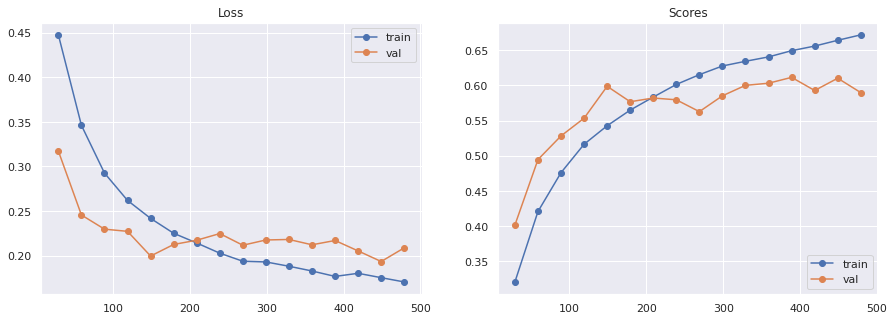

In [42]:
# show_loss_and_score(train_info, start_from=1)
show_loss_and_score(train_info)

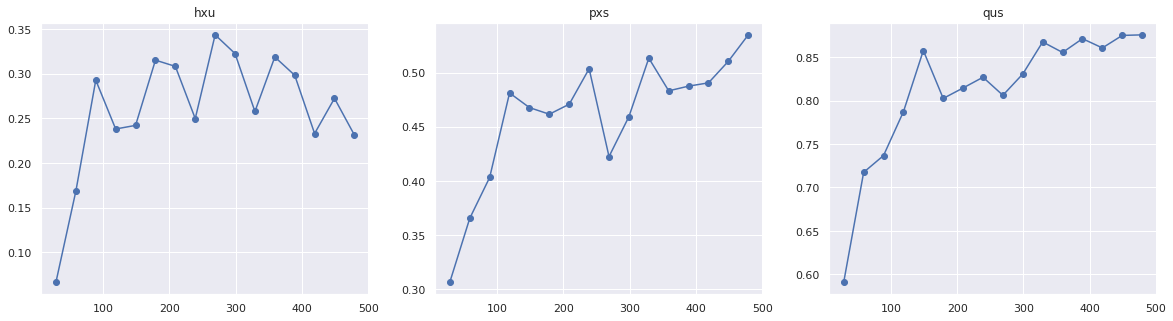

In [43]:
show_valid_score_by_flood(train_info)

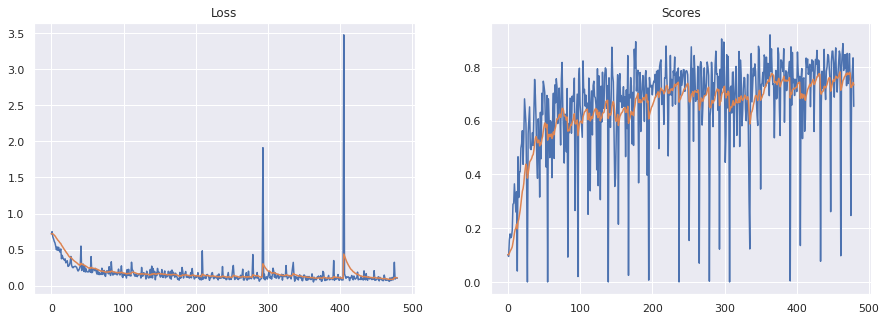

In [44]:
loss_meter = train_info['train_loss_meter']
score_meter = train_info['train_score_meter']
show_train_metrics(loss_meter, score_meter)

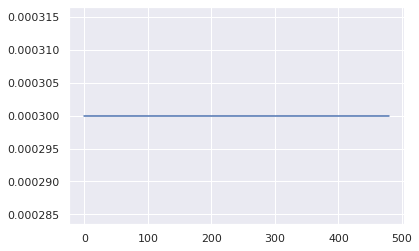

In [38]:
plt.plot(train_info['lr_history'])

# Validation 

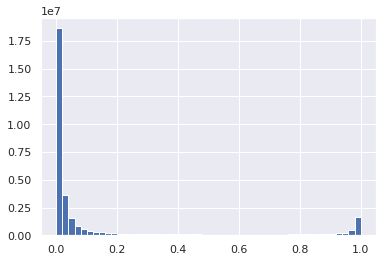

In [39]:
# TODO: pick threshold using this plot
valid_outputs = train_info['valid_outputs']
# len(valid_outputs), valid_outputs[0].shape, 512*512*32
plt.hist(np.concatenate(valid_outputs), bins=50)
plt.show()

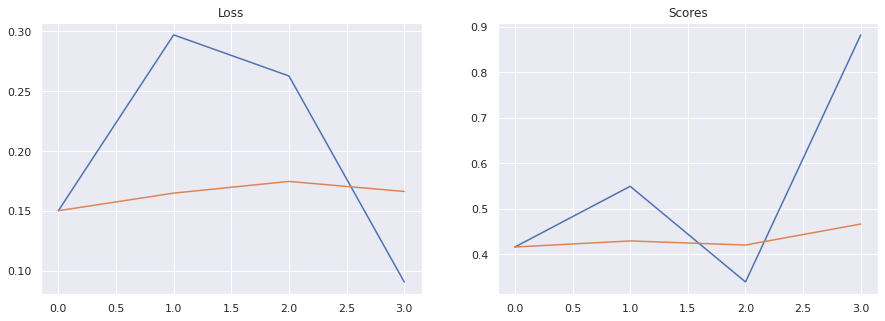

In [40]:
loss_meter = train_info['valid_loss_meter']
score_meter = train_info['valid_score_meter']
show_train_metrics(loss_meter, score_meter)

In [22]:
from dataset import FloodDataset
from main import get_data_by_flood_id
from train import validate

In [ ]:
# model = get_model().to(device)

In [23]:
# valid_dataset = train_info['valid_dataset']

flood_id = 'hxu' # qus kuo hxu
val_x, val_y = get_data_by_flood_id(PATH_TO_DATA, flood_id)
valid_dataset = FloodDataset(val_x, val_y, transforms=None)

[data] Dataset size: 26


In [32]:
loss = nn.CrossEntropyLoss(ignore_index=255)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
loss_meter, score_meter, outputs = validate(model, device, valid_loader, loss, print_every=1)

[valid] iter:    0, loss = 0.16806, score = 0.28734, time: 0:00:07
[valid] iter:    1, loss = 0.18635, score = 0.27321, time: 0:00:14
[valid] iter:    2, loss = 0.18158, score = 0.30804, time: 0:00:21
[valid] iter:    3, loss = 0.17597, score = 0.29807, time: 0:00:23


In [33]:
# show_train_metrics(loss_meter, score_meter)

In [34]:
score_meter.compute_score()

tensor(0.2981)

In [ ]:
score_meter.intersection, score_meter.union

(tensor(196529), tensor(352819))

# Show predictions

In [24]:
os.listdir('pth')

['unet_timm-efficientnet-b0_v3.pth',
 'unet_timm-efficientnet-b0_v2_389.pth',
 'unet_timm-efficientnet-b0_V2_10.09.pth']

In [29]:
model = get_model().to(device)

In [30]:
model_path = 'pth/unet_timm-efficientnet-b0_V2_10.09.pth'
# model.load_state_dict(torch.load(model_path))
model.load_state_dict(torch.load(model_path, map_location='cpu'))

model = model.eval()
# model = model.train()

In [31]:
# valid_dataset = train_info['valid_dataset']
len(valid_dataset)

26

In [35]:
valid_sample = valid_dataset[1]

chip = valid_sample['chip']
label = valid_sample['label']

chip.shape, label.shape

((2, 512, 512), (512, 512))

In [ ]:
def create_fcc_dataset_sample(s1_img):
    s1_img = np.transpose(s1_img, [1, 2, 0])
    
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    
    b_channel = s1_img[:, :, 0] / s1_img[:, :, 1]
    bc_max = b_channel.max()
    bc_min = b_channel.min()
    b_channel = (b_channel - bc_min) / (bc_max - bc_min)       
    img[:, :, 2] = b_channel

    return img

In [ ]:
fcc = create_fcc_dataset_sample(chip)
fcc.shape

(512, 512, 3)

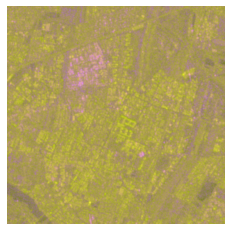

In [ ]:
show_image(fcc)

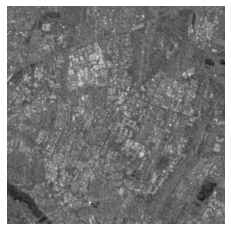

In [ ]:
show_image(fcc[:,:,0], cmap='gray')

In [ ]:
# plt.hist(chip[0].reshape(-1), bins=50)

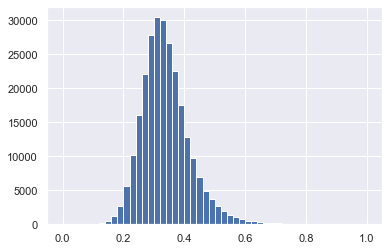

In [ ]:
plt.hist(fcc[:,:,2].reshape(-1), bins=50)
plt.show()

In [36]:
from metrics import IoUMeter
from train import compute_prediction
from plot_utils import show_predictions, get_chip_by_id

In [37]:
meter = IoUMeter()

In [38]:
def get_prediction(model, chip, label):
    chip = torch.tensor(chip).unsqueeze(0).to(device)
    # mask = torch.tensor(mask).to(device)
    label = torch.tensor(label).to(device)
    
    output = model(chip)
    pred = compute_prediction(output).squeeze()
        
    iou, inter, union = meter.update(pred, label)
    print(f'IoU: {iou:.5f}, inter: {inter}, union: {union}')
    print(f'Total IoU: {meter.compute_score():.5f}')
    
    return pred

In [39]:
def get_and_show_predictions(index, model, valid_dataset):    
    valid_sample = valid_dataset[index]
    
    chip_id = valid_sample['chip_id']  
    chip_to_show = get_chip_by_id(chip_id, train_metadata)
    print(f'Chip: {chip_id}')
    
    label = valid_sample['label']  
    label_to_show = np.ma.masked_where((label == 0) | (label == 255), label)
    
    label_sum = (1 - label_to_show.mask).sum()
    print(f'Label: {label_sum}')
    
    chip = valid_sample['chip']
    pred = get_prediction(model, chip, label).cpu()
    pred_to_show = np.ma.masked_where(pred == 0, pred)
    
    show_predictions(chip_to_show, chip, label_to_show, pred_to_show)

In [40]:
# np.array(meter.history).mean()

Chip: hxu01
Label: 28395
IoU: 0.24431, inter: 12962, union: 53056
Total IoU: 0.24431


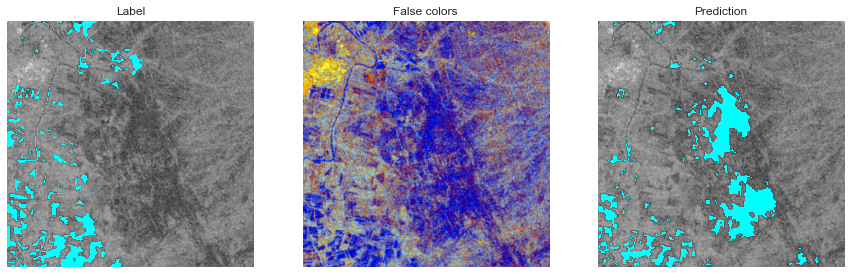

In [41]:
index = 1 # 4 19
meter.reset()
get_and_show_predictions(index, model, valid_dataset)

IoU: 0.0 
Total IoU: 0.0


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


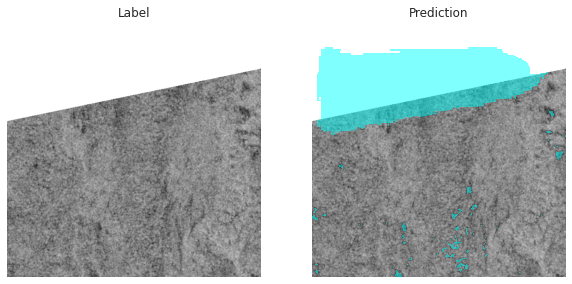

In [ ]:
index = 19
meter.reset()
get_and_show_predictions(index, model, valid_dataset)

In [42]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [43]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(valid_dataset)-1,
    step=1,
    description='Index:',
    disabled=False
)

def handle_change(x):
    get_and_show_predictions(x, model, valid_dataset)

In [44]:
meter.reset()
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Index:', max=25), Output()), _dom_classes=('widget-…

<function __main__.handle_change(x)>

In [ ]:
Inspecting prediction on hxu

unet_timm-efficientnet-b0_V2_10.09.pth

- a lot of false positives as expected

In [ ]:
Inspecting prediction on kuo

9.09 unet_timm-efficientnet-b0_v2_389

- small details unlikely affects us?
- when detecting a lot of water the metric goes up very quickly (kuo12)
- bright red areas hardly distinguishable at VV VH images (kuo47)

- false positive predictions
- detecting what we call "bad labeling" (kuo14)
- detecting bright red areas (kuo17, kuo19, kuo47)

- do not fill label completely
- do not detecting big water with small red dots (kuo06)
- bad at predicting rivers